#**Практическое задание №1**

Установка необходимых пакетов:

In [1]:
!pip install -q tqdm
!pip install --upgrade --no-cache-dir gdown

Монтирование Вашего Google Drive к текущему окружению:

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
cd /content/drive/MyDrive/DL/test

/content/drive/MyDrive/DL/test


Константы, которые пригодятся в коде далее, и ссылки (gdrive идентификаторы) на предоставляемые наборы данных:

In [ ]:
'''
EVALUATE_ONLY = True
TEST_ON_LARGE_DATASET = True
TISSUE_CLASSES = ('ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM')
DATASETS_LINKS = {
    'train': '1kT3GtZWcLqeuPECEGNXpMNi3jp9LZY_B',
    'train_small': '1IMMjP6oUFNmrDnmPRpuFt5vzHDGfELMY',
    'train_tiny': '1Ay1nq2ngf4XyVgE-d8S_z19dfD5PNszy',
    'test': '1EdCDUOB3bJLSkt117v-eSbIXiERur1Xr',
    'test_small': '1vF2YdizwJmsuzEY0hasrFnpE-uPoGAO_',
    'test_tiny': '1-2mhSO6nMSkm1Q61pbQb_QAwsGE_FuIu'
}
'''

In [ ]:
"""
import gdown

DATASETS_LINKS = {
    'train': '1XtQzVQ5XbrfxpLHJuL0XBGJ5U7CS-cLi',
    'train_small': '1qd45xXfDwdZjktLFwQb-et-mAaFeCzOR',
    'train_tiny': '1I-2ZOuXLd4QwhZQQltp817Kn3J0Xgbui',
    'test': '1RfPou3pFKpuHDJZ-D9XDFzgvwpUBFlDr',
    'test_small': '1wbRsog0n7uGlHIPGLhyN-PMeT2kdQ2lI',
    'test_tiny': '1viiB0s041CNsAK4itvX8PnYthJ-MDnQc'
}
"""
'''for name, file_id in DATASETS_LINKS.items():
    url = f"https://drive.google.com/uc?export=download&id={file_id}"
    output = f"{name}.zip"  # Название файла для сохранения
    print(f"Скачивание {name} из {url}...")
    gdown.download(url, output, quiet=False)

print("Скачивание завершено!")
'''
"""

'\nDATASETS_LINKS = {\n    \'train\': \'1XtQzVQ5XbrfxpLHJuL0XBGJ5U7CS-cLi\',\n    \'train_small\': \'1qd45xXfDwdZjktLFwQb-et-mAaFeCzOR\',\n    \'train_tiny\': \'1I-2ZOuXLd4QwhZQQltp817Kn3J0Xgbui\',\n    \'test\': \'1RfPou3pFKpuHDJZ-D9XDFzgvwpUBFlDr\',\n    \'test_small\': \'1wbRsog0n7uGlHIPGLhyN-PMeT2kdQ2lI\',\n    \'test_tiny\': \'1viiB0s041CNsAK4itvX8PnYthJ-MDnQc\'\n}\n\n\'\'\'for name, file_id in DATASETS_LINKS.items():\n    url = f"https://drive.google.com/uc?export=download&id={file_id}"\n    output = f"{name}.zip"  # Название файла для сохранения\n    print(f"Скачивание {name} из {url}...")\n    gdown.download(url, output, quiet=False)\n\nprint("Скачивание завершено!")\n\'\'\'\n'

Импорт необходимых зависимостей:

In [ ]:
'''
from pathlib import Path
import numpy as np
from typing import List
from tqdm.notebook import tqdm
from time import sleep
from PIL import Image
import IPython.display
from sklearn.metrics import balanced_accuracy_score
import gdown
import matplotlib.pyplot as plt
from collections import Counter

import random
import torch
import torchvision.transforms as transforms
'''

(ЗАМЕНИЛ НА СОБСТВЕННЫЙ)
---
### Класс Dataset(ЗАМЕНИЛ НА СОБСТВЕННЫЙ)

Предназначен для работы с наборами данных, обеспечивает чтение изображений и соответствующих меток, а также формирование пакетов (батчей).

In [ ]:
'''
class Dataset:

    def __init__(self, name, transform=None):
        self.name = name
        self.is_loaded = False
        self.transform = transform  # Добавляем трансформации
        ''' Если уже лежат в локальной директории '''
        #url = f"https://drive.google.com/uc?export=download&confirm=pbef&id={DATASETS_LINKS[name]}"
        #output = f'{name}.npz'
        #gdown.download(url, output, quiet=False)
        #print(f'Loading dataset {self.name} from npz.')

        np_obj = np.load(f'{name}.npz')
        self.images = np_obj['data']
        self.labels = np_obj['labels']
        self.n_files = self.images.shape[0]
        self.is_loaded = True
        print(f'Done. Dataset {name} consists of {self.n_files} images.')


    def __len__(self):
        # Возвращаем количество файлов в датасете
        return self.n_files

    def __getitem__(self, idx):
        # Получаем i-е изображение и метку
        img, lbl = self.images[idx], self.labels[idx]

        # Преобразуем изображение из numpy в PIL для использования transforms
        img = Image.fromarray(img)

        # Применяем трансформации, если они указаны
        if self.transform:
            img = self.transform(img)

        return img, lbl
    def image(self, i):
        # read i-th image in dataset and return it as numpy array
        if self.is_loaded:
            return self.images[i, :, :, :]

    def images_seq(self, n=None):
        # sequential access to images inside dataset (is needed for testing)
        for i in range(self.n_files if not n else n):
            yield self.image(i)

    def random_image_with_label(self):
        # get random image with label from dataset
        i = np.random.randint(self.n_files)
        return self.image(i), self.labels[i]

    def random_batch_with_labels(self, n):
        # create random batch of images with labels (is needed for training)
        indices = np.random.choice(self.n_files, n)
        imgs = []
        for i in indices:
            img = self.image(i)
            imgs.append(self.image(i))
        logits = np.array([self.labels[i] for i in indices])
        return np.stack(imgs), logits

    def image_with_label(self, i: int):
        # return i-th image with label from dataset
        return self.image(i), self.labels[i]
'''

### Пример использвания класса Dataset
Загрузим обучающий набор данных, получим произвольное изображение с меткой. После чего визуализируем изображение, выведем метку. В будущем, этот кусок кода можно закомментировать или убрать.

Done. Dataset train_tiny consists of 900 images.

Got numpy array of shape (224, 224, 3), and label with code 3.
Label code corresponds to LYM class.


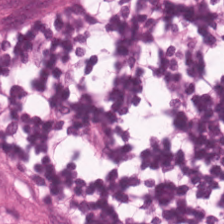

In [ ]:
'''
d_train_tiny = Dataset('train_tiny')

img, lbl = d_train_tiny.random_image_with_label()
print()
print(f'Got numpy array of shape {img.shape}, and label with code {lbl}.')
print(f'Label code corresponds to {TISSUE_CLASSES[lbl]} class.')

pil_img = Image.fromarray(img)
IPython.display.display(pil_img)
'''

# Модель

In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torchvision import transforms, models
from torchvision.models import EfficientNet_B3_Weights
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import wandb
import os
from PIL import Image
import matplotlib.pyplot as plt

In [5]:
#LBL12
# Инициализация WANDB(крутой сервис для визуализации и подбора гипер-параметров)
wandb.init(project="histology-classification", config={
    "epochs": 20,
    "batch_size": 32,
    "learning_rate": 1e-4,
    "num_folds": 5,
    "augmentation_epochs": 12,  # Эпохи с аугментацией(меньше чем количество эпох обучения)
    "optimizer": "adam"
})

# Получаем гиперпараметры из wandb
config = wandb.config

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: vortex_d11 (vortex_d11-m-v-lomonosovmoscow-state-university). Use `wandb login --relogin` to force relogin


In [6]:
class Dataset(data.Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
        self.n_files = self.images.shape[0]

    def __len__(self):
        return self.n_files

    def __getitem__(self, idx):
        img, lbl = self.images[idx], self.labels[idx]
        img = Image.fromarray(img)
        if self.transform:
            img = self.transform(img)
        return img, lbl

In [7]:
class Trainer:
    def __init__(self, train_dataset=None, val_dataset=None, num_classes=9, config=None):
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.num_classes = num_classes
        self.config = config or {}
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = self._initialize_model()
        self.criterion = nn.CrossEntropyLoss()

        if self.train_dataset is not None and self.val_dataset is not None:
            self.optimizer = self._initialize_optimizer()
            self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, 'min')

        self.checkpoint_dir = "/content/drive/MyDrive/checkpoints" #Гугл-диск
        os.makedirs(self.checkpoint_dir, exist_ok=True)

    def _initialize_model(self):
        weights = EfficientNet_B3_Weights.IMAGENET1K_V1
        model = models.efficientnet_b3(weights=weights)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, self.num_classes)
        return model.to(self.device)

    def _initialize_optimizer(self):
        if self.config.optimizer == "adam":
            optimizer = optim.Adam(self.model.parameters(), lr=self.config.learning_rate)
        elif self.config.optimizer == "sgd":
            optimizer = optim.SGD(self.model.parameters(), lr=self.config.learning_rate, momentum=0.9)
        else:
            raise ValueError(f"Unsupported optimizer: {self.config.optimizer}")
        return optimizer

    def train(self):
        train_loader = data.DataLoader(self.train_dataset, batch_size=self.config.batch_size, shuffle=True)
        val_loader = data.DataLoader(self.val_dataset, batch_size=self.config.batch_size, shuffle=False)

        best_val_loss = float('inf')  # Чтобы сохранить лучшую модель
        for epoch in range(self.config.epochs):
            print(f'Epoch {epoch + 1}/{self.config.epochs}')
            self._train_one_epoch(train_loader, epoch)
            val_loss = self._validate(val_loader)
            self.scheduler.step(val_loss)
            wandb.log({"epoch": epoch, "val_loss": val_loss})

            # Сохраняем лучшую модель
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                self._save_checkpoint(epoch, is_best=True)

        # Сохраняем модель после окончания обучения
        self._save_model()
        # Тест модели
        self._test(val_loader)

    def _train_one_epoch(self, loader, epoch):
        self.model.train()
        running_loss = 0.0
        for inputs, labels in loader:
            inputs, labels = inputs.to(self.device), labels.to(self.device)

            # Так как модель предобученная, то применяется лишь аугментация до "средних" эпох, ибо слишком привыкает если оставлять до конца
            if epoch >= self.config.epochs - self.config.augmentation_epochs:
                inputs = self._augment_data(inputs)

            self.optimizer.zero_grad()
            outputs = self.model(inputs)
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()

            running_loss += loss.item()
            wandb.log({"train_loss": loss.item()})

        epoch_loss = running_loss / len(loader)
        print(f'Training Loss: {epoch_loss:.4f}')

    def _validate(self, loader):
        self.model.eval()
        running_loss = 0.0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for inputs, labels in loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                running_loss += loss.item()

                preds = torch.argmax(outputs, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        #LBL5
        val_loss = running_loss / len(loader)
        val_accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
        print(f'Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}')
        wandb.log({"val_accuracy": val_accuracy})
        return val_loss

    def _test(self, loader):
        self.model.eval()
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for inputs, labels in loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.model(inputs)
                preds = torch.argmax(outputs, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        # Cinfussion matrix(почти как в лекциях)
        cm = confusion_matrix(all_labels, all_preds)
        cr = classification_report(all_labels, all_preds, output_dict=True)
        wandb.log({"confusion_matrix": wandb.plot.confusion_matrix(probs=None,
                                                                   y_true=all_labels,
                                                                   preds=all_preds,
                                                                   class_names=[str(i) for i in range(self.num_classes)])})
        #LBL8
        # Чувствительность и специфичность
        sensitivity = np.diag(cm) / np.sum(cm, axis=1)
        specificity = np.diag(cm) / np.sum(cm, axis=0)
        print(f'Sensitivity: {sensitivity}')
        print(f'Specificity: {specificity}')
        wandb.log({"sensitivity": sensitivity.mean(), "specificity": specificity.mean()})

        # Выгружаем результаты тестирования, нужные для первичной "оценки" модели
        #LBL9
        np.savez("val_results.npz", preds=all_preds, labels=all_labels)

    def _augment_data(self, inputs):
        #LBL10
        augmentation = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomRotation(15)
        ])
        augmented_inputs = []
        for img in inputs:
            img = transforms.ToPILImage()(img.cpu())
            img = augmentation(img)
            img = transforms.ToTensor()(img)
            augmented_inputs.append(img)
        return torch.stack(augmented_inputs).to(self.device)
    #LBL3
    def _save_checkpoint(self, epoch, is_best=False):
        checkpoint_path = os.path.join(self.checkpoint_dir, f'model_epoch_{epoch}.pth')
        torch.save({
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
        }, checkpoint_path)
        print(f'Checkpoint saved at {checkpoint_path}')

        if is_best:
            best_model_path = os.path.join(self.checkpoint_dir, f'best_model.pth')
            torch.save(self.model.state_dict(), best_model_path)
            print(f'Best model saved at {best_model_path}')

        # WANDB moment
        artifact = wandb.Artifact('model', type='model')
        artifact.add_file(checkpoint_path)
        wandb.log_artifact(artifact)

    def _save_model(self):
        # Сохранение финальных весов модели для дальнейшей работы
        final_model_path = os.path.join(self.checkpoint_dir, f'final_model.pth')
        torch.save(self.model.state_dict(), final_model_path)
        print(f'Final model saved at {final_model_path}')

        # Нужно для wandb
        artifact = wandb.Artifact('final_model', type='model')
        artifact.add_file(final_model_path)
        wandb.log_artifact(artifact)

    def load_model(self, model_path):
        #LBL11
        # Загрузка весов модели для инференса или дообучения
        self.model.load_state_dict(torch.load(model_path, map_location=self.device))
        self.model.to(self.device)
        print(f'Model loaded from {model_path}')
    #LBL4
    def load_checkpoint(self, checkpoint_path):
        checkpoint = torch.load(checkpoint_path, map_location=self.device)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        print(f'Checkpoint loaded, resuming training from epoch {start_epoch}')
        # Если есть чекпоинты, то можем стартовать с последнего. Нужно, если вдруг аварийно все сломается или закроется
        return start_epoch

    def test_on_dataset(self, dataset, limit=None):
        self.model.eval()
        predictions = []
        true_labels = []
        n = len(dataset) if limit is None else int(len(dataset) * limit)
        loader = data.DataLoader(dataset, batch_size=1, shuffle=False)
        for i, (img, label) in enumerate(loader):
            if i >= n:
                break
            img = img.to(self.device)
            with torch.no_grad():
                output = self.model(img)
                pred = torch.argmax(output, dim=1).cpu().item()
                predictions.append(pred)
                true_labels.append(label.item())
        return predictions, true_labels

    def test_on_image(self, img):
        self.model.eval()
        img_tensor = self.transforms(img).unsqueeze(0).to(self.device)
        with torch.no_grad():
            output = self.model(img_tensor)
            pred = torch.argmax(output, dim=1).cpu().item()
        return pred

In [8]:
def inference(model, dataloader, device):
    model.eval()
    predictions = []
    with torch.no_grad():
        for inputs, _ in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)
            predictions.extend(preds.cpu().numpy())
    return predictions

In [20]:
# Основная функция
def main():
    # Приводим к адекватному представлению, для того чтобы модель "скушала" наши данные
    data_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])

    # Обучаем на самом большом(из предложенных) датасете - train
    np_obj = np.load('train.npz')
    images = np_obj['data']
    labels = np_obj['labels']
                                                                #LBL1
    train_images, test_images, train_labels, test_labels = train_test_split(
        images, labels, test_size=0.1, stratify=labels, random_state=42)

    test_dataset = Dataset(test_images, test_labels, transform=data_transforms)
    test_loader = data.DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False)

    kfold_images = train_images
    kfold_labels = train_labels
    #LBL2
    kfold = KFold(n_splits=config.num_folds, shuffle=True, random_state=42)
    for fold, (train_idx, val_idx) in enumerate(kfold.split(kfold_images)):
        print(f'Fold {fold + 1}/{config.num_folds}')

        train_images_fold = kfold_images[train_idx]
        train_labels_fold = kfold_labels[train_idx]
        val_images_fold = kfold_images[val_idx]
        val_labels_fold = kfold_labels[val_idx]

        train_dataset = Dataset(train_images_fold, train_labels_fold, transform=data_transforms)
        val_dataset = Dataset(val_images_fold, val_labels_fold, transform=data_transforms)

        trainer = Trainer(train_dataset, val_dataset, config=config)

        latest_checkpoint = None
        if os.path.exists(trainer.checkpoint_dir):
            checkpoints = [ckpt for ckpt in os.listdir(trainer.checkpoint_dir) if 'model_epoch' in ckpt and ckpt.endswith('.pth')]
            if checkpoints:
                latest_checkpoint = max(checkpoints, key=lambda x: int(x.split('_')[-1].split('.')[0]))
                latest_checkpoint = os.path.join(trainer.checkpoint_dir, latest_checkpoint)

        if latest_checkpoint:
            start_epoch = trainer.load_checkpoint(latest_checkpoint)
        else:
            start_epoch = 0

        trainer.train()

        print("Testing on independent test set:")
        trainer.load_model(os.path.join(trainer.checkpoint_dir, 'best_model.pth'))
        test_results(trainer.model, test_loader, trainer.device)

        # Визуализация результатов тестирования
        visualize_results()

        # если не хотим тратить ресурсы(а модель хорошо обучается и без дополнительных fold'ов)
        break
        # если нужны фолды(к-в), то убрать break

def test_results(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    cr = classification_report(all_labels, all_preds, output_dict=True)
    #LBL6
    wandb.log({"test_confusion_matrix": wandb.plot.confusion_matrix(probs=None,
                                                                    y_true=all_labels,
                                                                    preds=all_preds,
                                                                    class_names=[str(i) for i in range(model.classifier[1].out_features)])})

    sensitivity = np.diag(cm) / np.sum(cm, axis=1)
    specificity = np.diag(cm) / np.sum(cm, axis=0)
    print(f'Test Sensitivity: {sensitivity}')
    print(f'Test Specificity: {specificity}')
    wandb.log({"test_sensitivity": sensitivity.mean(), "test_specificity": specificity.mean()})
    #LBL7
    np.savez("test_results.npz", preds=all_preds, labels=all_labels)

def visualize_results():
    results = np.load("test_results.npz")
    preds = results['preds']
    labels = results['labels']

    # Построение графиков
    plt.figure(figsize=(10, 5))
    plt.hist([preds, labels], label=['Predictions', 'Ground Truth'], bins=np.arange(10)-0.5, rwidth=0.8)
    plt.xticks(range(9))
    plt.legend()
    plt.title('Distribution of Predictions and Ground Truth on Test Set')
    plt.savefig('test_results.png')
    wandb.log({"test_results": wandb.Image('test_results.png')})

# ОБУЧЕНИЕ

In [21]:
if __name__ == "__main__":
    main()

FileNotFoundError: [Errno 2] No such file or directory: 'train.npz'

# МЕТРИКИ

In [19]:
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

np_obj = np.load('test.npz')
test_images = np_obj['data']
test_labels = np_obj['labels']
test_dataset = Dataset(test_images, test_labels, transform=data_transforms)

trainer = Trainer(config=config)
trainer.transforms = data_transforms

best_model_path = os.path.join(trainer.checkpoint_dir, 'best_model.pth')
trainer.load_model(best_model_path)

predictions, true_labels = trainer.test_on_dataset(test_dataset)

from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(true_labels, predictions)
print("Confusion Matrix:")
print(cm)
cr = classification_report(true_labels, predictions, digits=4)
print("Classification Report:")
print(cr)


<ipython-input-7-47f6d900142e>:178: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(model_path, map_location=self.device))


Model loaded from /content/drive/MyDrive/checkpoints/best_model.pth
Confusion Matrix:
[[ 9  0  0  0  0  1  0  0  0]
 [ 0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0]
 [ 0  0  0 10  0  0  0  0  0]
 [ 0  0  0  0 10  0  0  0  0]
 [ 0  0  0  0  0 10  0  0  0]
 [ 0  0  0  0  0  0 10  0  0]
 [ 0  0  0  0  0  0  0 10  0]
 [ 0  0  0  0  0  0  0  0 10]]
Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.9000    0.9474        10
           1     1.0000    1.0000    1.0000        10
           2     1.0000    1.0000    1.0000        10
           3     1.0000    1.0000    1.0000        10
           4     1.0000    1.0000    1.0000        10
           5     0.9091    1.0000    0.9524        10
           6     1.0000    1.0000    1.0000        10
           7     1.0000    1.0000    1.0000        10
           8     1.0000    1.0000    1.0000        10

    accuracy                         0.9889        90
   macro avg     0.9899 

In [10]:
from typing import List
from sklearn.metrics import balanced_accuracy_score

In [11]:
class Metrics:

    @staticmethod
    def accuracy(gt: List[int], pred: List[int]):
        assert len(gt) == len(pred), 'gt and prediction should be of equal length'
        return sum(int(i[0] == i[1]) for i in zip(gt, pred)) / len(gt)

    @staticmethod
    def accuracy_balanced(gt: List[int], pred: List[int]):
        return balanced_accuracy_score(gt, pred)

    @staticmethod
    def print_all(gt: List[int], pred: List[int], info: str):
        print(f'metrics for {info}:')
        print('\t accuracy {:.4f}:'.format(Metrics.accuracy(gt, pred)))
        print('\t balanced accuracy {:.4f}:'.format(Metrics.accuracy_balanced(gt, pred)))

In [12]:
def test_results1(model, loader, device, class_names):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())


    Metrics.print_all(all_labels, all_preds, 'test')

In [34]:
def main():
    data_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])

    trainer = Trainer(config=config)
    trainer.model.to(trainer.device)


    best_model_path = os.path.join(trainer.checkpoint_dir, 'best_model.pth')
    trainer.load_model(best_model_path)


    test_data = np.load('test_tiny.npz')
    test_images = test_data['data']
    test_labels = test_data['labels']
    test_dataset = Dataset(test_images, test_labels, transform=data_transforms)
    test_loader = data.DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False)

    class_names = ['ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM']

    print("Evaluating model:")
    test_results1(trainer.model, test_loader, trainer.device, class_names)

    #visualize_results()

In [35]:
main()

<ipython-input-8-47f6d900142e>:178: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(model_path, map_location=self.device))


Model loaded from /content/drive/MyDrive/checkpoints/best_model.pth
Evaluating model:
metrics for test:
	 accuracy 0.9889:
	 balanced accuracy 0.9889:


# ПРИМЕР С СОЗДАНИЕМ НЕСБАЛАНСИРОВАННОГО ДАТАСЕТА

In [ ]:
from collections import Counter

def create_unbalanced_dataset(images, labels, class_ratios):

    unbalanced_images = []
    unbalanced_labels = []
    unique_classes = np.unique(labels)
    for cls in unique_classes:
        cls_indices = np.where(labels == cls)[0]
        n_samples = int(len(cls_indices) * class_ratios.get(cls, 1.0))
        selected_indices = np.random.choice(cls_indices, n_samples, replace=False)
        unbalanced_images.append(images[selected_indices])
        unbalanced_labels.append(labels[selected_indices])
    unbalanced_images = np.concatenate(unbalanced_images)
    unbalanced_labels = np.concatenate(unbalanced_labels)
    return unbalanced_images, unbalanced_labels


In [ ]:
test_data = np.load('test.npz')
test_images = test_data['data']
test_labels = test_data['labels']

In [ ]:
class_ratios = {
    1: 0.15, # 15% от 1класса(забыл какой там)
    3: 0.5, # Оставить 50% от класса LYM
    4: 0.10, # Оставить 10% от класса MUC
    5: 0.05, # Оставить 5% от класса MUS
}

unbalanced_images, unbalanced_labels = create_unbalanced_dataset(test_images, test_labels, class_ratios)

In [ ]:
unbalanced_dataset = Dataset(unbalanced_images, unbalanced_labels, transform=data_transforms)
unbalanced_loader = data.DataLoader(unbalanced_dataset, batch_size=config.batch_size, shuffle=False)

In [ ]:
print("Evaluating model on unbalanced test dataset:")
test_results1(trainer.model, unbalanced_loader, trainer.device, class_names)

Evaluating model on unbalanced test dataset:
metrics for test:
	 accuracy 0.9914:
	 balanced accuracy 0.9944:


# ЗАГРУЗКА МОДЕЛИ С ДРАЙВА

In [13]:
import gdown

In [14]:
# Ссылка на модель в Google Drive

url_model1 = "https://drive.google.com/uc?export=download&id=117ANVkbp1Ktn4iQllV7JOEdXHL0wk8N6"

#Точно ссылка на модель(продублирую еще в README ссылку на директорию и /content/drive/MyDrive/checkpoints/best_model.pth)

model_w = "model_weights.pth"

gdown.download(url_model1, model_w, quiet=False)

print(f"Файл {model_w} успешно скачан.")


Downloading...
From (original): https://drive.google.com/uc?export=download&id=117ANVkbp1Ktn4iQllV7JOEdXHL0wk8N6
From (redirected): https://drive.google.com/uc?export=download&id=117ANVkbp1Ktn4iQllV7JOEdXHL0wk8N6&confirm=t&uuid=fbe7890b-dd88-4d92-98d4-b8959aaad7f5
To: /content/drive/MyDrive/DL/test/model_weights.pth
100%|██████████| 43.4M/43.4M [00:00<00:00, 73.2MB/s]

Файл model_weights.pth успешно скачан.


In [15]:
#Ссылки на представленные датасеты на моем(!) gd(из-за проблем с диском)
import gdown

DATASETS_LINKS = { #Возможно где-то ошибься с ссылками...
    'train': '1kT3GtZWcLqeuPECEGNXpMNi3jp9LZY_B',
    'train_small': '1IMMjP6oUFNmrDnmPRpuFt5vzHDGfELMY',
    'train_tiny': '1Ay1nq2ngf4XyVgE-d8S_z19dfD5PNszy',
    'test': '1EdCDUOB3bJLSkt117v-eSbIXiERur1Xr',
    'test_small': '1vF2YdizwJmsuzEY0hasrFnpE-uPoGAO_',
    'test_tiny': '1pxwyXm4bSsAtnlfujjfUrHldkHeJg76A'
}

name = "test_tiny"

file_id = DATASETS_LINKS[name]
output = f'{name}.npz'

gdown.download(id=file_id, output=output, quiet=False)

print(f'Загружаем датасет {name} из файла npz.')


Downloading...
From: https://drive.google.com/uc?id=1pxwyXm4bSsAtnlfujjfUrHldkHeJg76A
To: /content/drive/MyDrive/DL/test/test_tiny.npz
100%|██████████| 10.6M/10.6M [00:00<00:00, 52.0MB/s]

Загружаем датасет test_tiny из файла npz.


In [16]:
def main():
    data_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])

    trainer = Trainer(config=config)
    trainer.model.to(trainer.device)


    trainer.load_model(model_w)


    test_data = np.load(f'{name}.npz')
    test_images = test_data['data']
    test_labels = test_data['labels']
    test_dataset = Dataset(test_images, test_labels, transform=data_transforms)
    test_loader = data.DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False)

    class_names = ['ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM']

    print("Evaluating model:")
    test_results1(trainer.model, test_loader, trainer.device, class_names)

    #visualize_results()

In [17]:
main()

<ipython-input-7-47f6d900142e>:178: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(model_path, map_location=self.device))


Model loaded from model_weights.pth
Evaluating model:
metrics for test:
	 accuracy 0.9889:
	 balanced accuracy 0.9889:
